The goal is to look at what happens when markets fall, in terms of correlations across the stocks in the market and to build a cap-weighted market index.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import risk_kit as kit
import pandas as pd
import numpy as np

In [2]:
ind_return = kit.get_ind_returns() 
#ind_return -Returns of any industry in any month, of the portfolio that consists
# the stocks in that industry for that month.

The way they computed this return (ind_return) is, they constructed a portfolio that was consisting of all the stocks in one industry (eg: food) and then they weighted those stocks by the market cap of each of those stocks. 

The MARKET CAP of the stock is simply the number of shares outstanding multiplied by the price.

One way to think about the market cap of the stock is, it is the total value of the company. (If you bought every single share of that stock that is out there, you own 100% of that company). That is market capitalization, and in a sense, is really the market price of that company at that moment.

If you add up all the market caps of all the companies, that is the total market size.

If you are building a portfolio where all the individual stocks in that portfolio, are proportionate to how big they are (how much value is embedded in that stock price), then you would weigh it by the market caps, and that's how the SP 500, or the FTSE 100 or the MSCI indices are done with a minor correction for liquidity, which is what they call the float adjustment.


GOAL: We are going to construct a market index very similar to a cap-weighted index (without float adjustment) and then we will use that to understand what happens to correlations when that stock market index is rising, and when that stock market is falling.

To be able to create that market index, we have to figure out 2 things:

    -- What weight should you put for each industry portfolio. You need to know what is the total market capitalization of all the stocks in that industry. To know that, you need to know the number of firms that made up that industry. The ind30_m_nfirms.csv file tells you that.
    
    -- What is the size of those companies in that industry? The ind30_m_size.csv file tells you the size. We are going to be looking at the market cap weight and we can ignore the units for now.

In [3]:
ind_return = kit.get_ind_returns() 
ind_nfirms = kit.get_ind_nfirms()
ind_size = kit.get_ind_size()

In [4]:
# The shapes for all three (returns, firms and size) should be same
ind_return.shape

(1110, 30)

In [5]:
ind_nfirms.shape

(1110, 30)

In [6]:
ind_size.shape

(1110, 30)

In [7]:
ind_nfirms.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-08,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-09,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-10,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-11,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4


We have the source raw data. The first thing we need to construct the market cap index is, to find out the market capitalization for each of the industries. 

The Market Capitalization, is the market cap of each one of these industry portfolios over time. That is the number of firms times the average size.


In [8]:
ind_mktcap = ind_nfirms * ind_size
ind_mktcap.shape

(1110, 30)

Now, if you want to find the fraction of the total market capitalization that is in each industry, we need the total market capitalization. 

Total market cap is nothing more than each industry's market cap. ie; industry market cap.

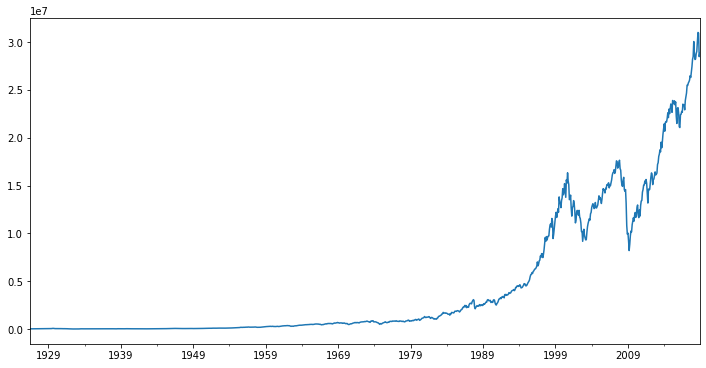

In [9]:
total_mktcap = ind_mktcap.sum("columns") # sum across columns
total_mktcap.plot(figsize=(12,6))

As we would expect, the market capitalization has dramatically gone up over time. And when the crashes happen, we lose a lot of market capitalization.

Next, we want the weight of each one of these industries over time, so we want the capitalization weight. 

The capitalization weights are derived by dividing each industry's market capitalization by the total market capitalization at that point in time. 

In [10]:
ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")
ind_capweight.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.058037,0.000801,0.035844,0.006935,0.000902,0.006683,0.008265,0.006701,0.036726,0.003014,...,0.065714,0.001531,0.014889,0.007956,0.185736,0.000089,0.057748,0.002435,0.008476,0.003639
1926-08,0.056578,0.000738,0.035264,0.006932,0.000972,0.006453,0.008673,0.006583,0.038497,0.002938,...,0.064380,0.001613,0.014732,0.008280,0.183379,0.000066,0.056014,0.002406,0.008258,0.003719
1926-09,0.056699,0.000917,0.036510,0.006810,0.001046,0.006038,0.008249,0.006668,0.039700,0.003109,...,0.064318,0.001609,0.014870,0.007873,0.187292,0.000068,0.054227,0.002339,0.008412,0.003879
1926-10,0.056920,0.000954,0.036736,0.007175,0.001028,0.006053,0.008139,0.006704,0.041486,0.003160,...,0.064896,0.001636,0.014850,0.007436,0.186812,0.000063,0.054280,0.002310,0.008280,0.003730
1926-11,0.056725,0.000951,0.038285,0.007047,0.001161,0.005924,0.008396,0.006831,0.040665,0.003269,...,0.066868,0.001642,0.015118,0.007236,0.187051,0.000054,0.054635,0.002279,0.008096,0.003521


It shows that in July 1926, the Food was 5.8% of total market cap. Chemicals were 3.6%

In [11]:
# The sum should give 100%
ind_capweight["1926"].sum(axis="columns")

<ipython-input-11-9c752dc06048>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ind_capweight["1926"].sum(axis="columns")


1926-07    1.0
1926-08    1.0
1926-09    1.0
1926-10    1.0
1926-11    1.0
1926-12    1.0
Freq: M, dtype: float64

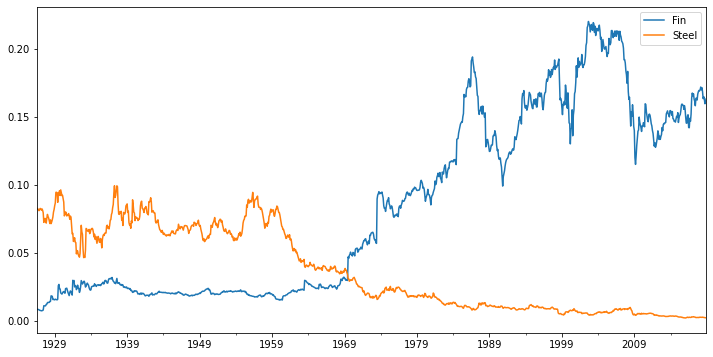

In [12]:
# Compare capweight of Finance and Steel
ind_capweight[["Fin","Steel"]].plot(figsize=(12,6))

Back in the day, steel companies were big part of the stock market. Finance companies are much bigger now than they used to be. 

Now we have got all the capweights for the individual components, so we can construct a cap-weighted market index, just like S&P 500.

What does S&P 500 do?

        It takes 500 stocks, the top 500 stocks and then it computes a portfolio that consists of the prices of all those    companies, or the values of all those companies, proportional to their market capitalization.
        
We are going to compute the exact same thing.

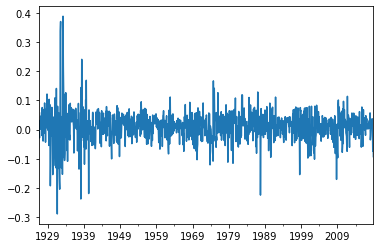

In [13]:
total_market_return = (ind_capweight*ind_return).sum(axis="columns") # weighted average of each one of the industries
total_market_return.plot()

Now, we have to take these returns and convert it into a total market index.

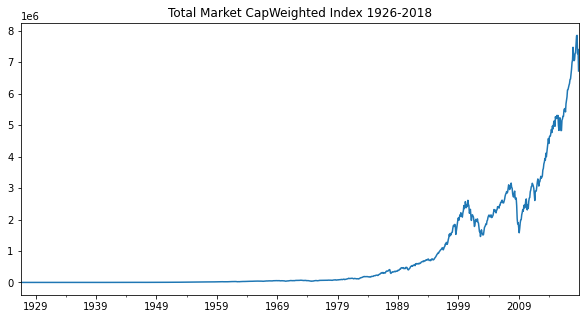

In [16]:
total_market_index = kit.drawdown(total_market_return).Wealth #Total market index is the Wealth index derived from the returns
total_market_index.plot(figsize=(10,5), title="Total Market CapWeighted Index 1926-2018")

Now we want to look at the returns of the market over a 3 year period. 

What we actually want to do is to look at how returns is related to market correlations.

Start by looking at the trailing 36 month return

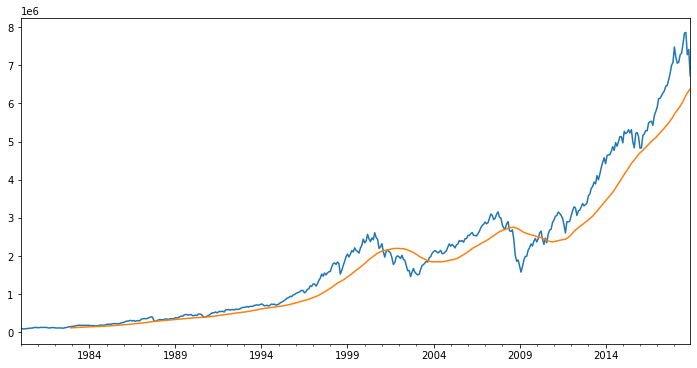

In [15]:
total_market_index["1980":].plot(figsize=(12,6))
total_market_index["1980":].rolling(window=36).mean().plot()

Rolling --> It is a rolling window, and it starts with a time series. It produces another timeseries, each element of that time series is computed out of a window of 36 months. The mean return in 36 month window is calculated above.

Note that the first data point requires 36 months, that is why the moving average out of the rolling window lacks data for the first 36 months.

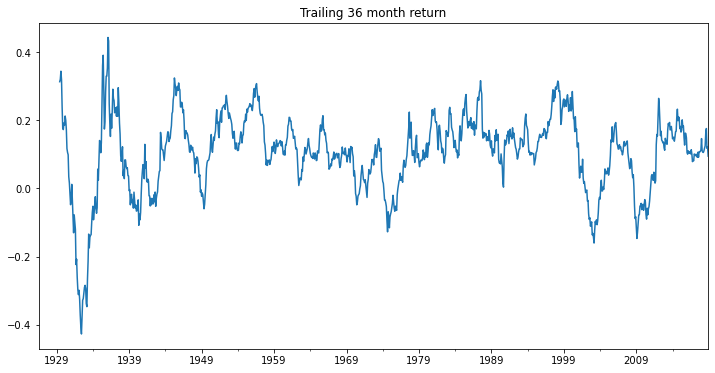

In [20]:
# Now, to look at total market index trailing 36-month returns 
tmi_tr36rets = total_market_return.rolling(window=36).aggregate(kit.annualize_rets, periods_per_year=12) # compound the returns
tmi_tr36rets.plot(figsize=(12,6), title="Trailing 36 month return")

The above graph shows compounded returns over 3 years from 1929. We want to look at actual returns for the same period of time.

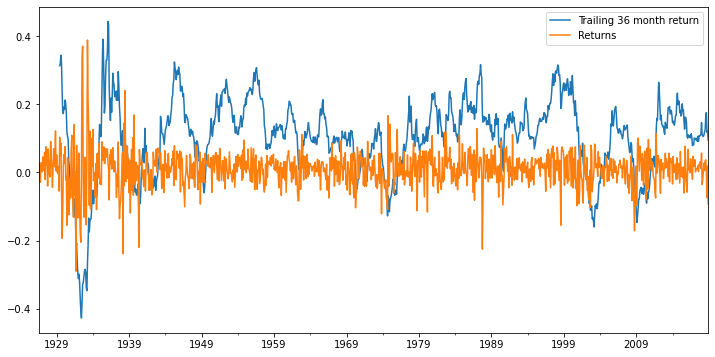

In [21]:
tmi_tr36rets.plot(figsize=(12,6), label="Trailing 36 month return", legend=True)
total_market_return.plot(label="Returns", legend=True)

We want to see if there is some relationship between market crash and correlation. We have to check if there is correlation potential in the down markets. 

To do that we need some measure to find, if the markets are correlating or decorrelating during these up and down markets. For this, measure the average correlation across industries.

### Rolling Correlation - along with MultiIndexes and .groupby

In [23]:
# Generate atime series of correlations
ts_corr = ind_return.rolling(window=36).corr()
ts_corr.tail()

Food      Beer     Smoke     Games     Books     Hshld  \
2018-12 Whlsl  0.474948  0.356983  0.122672  0.510425  0.803362  0.419280   
        Rtail  0.517856  0.406107  0.030283  0.676464  0.636320  0.358336   
        Meals  0.370187  0.385483  0.122007  0.301516  0.520649  0.308216   
        Fin    0.298823  0.192706  0.027593  0.480276  0.694812  0.162690   
        Other  0.436952  0.376565  0.224010  0.331829  0.558072  0.390610   

                  Clths      Hlth     Chems     Txtls  ...     Telcm  \
2018-12 Whlsl  0.570071  0.739764  0.785796  0.634197  ...  0.648092   
        Rtail  0.676598  0.714933  0.626034  0.634202  ...  0.562238   
        Meals  0.302176  0.416193  0.520023  0.491726  ...  0.406184   
        Fin    0.425899  0.658468  0.760151  0.577090  ...  0.420863   
        Other  0.467099  0.645035  0.712511  0.520953  ...  0.607868   

                  Servs     BusEq     Paper     Trans     Whlsl     Rtail  \
2018-12 Whlsl  0.567395  0.543362  0.764252  0.829185  1.000000  0.744842   
        Rtail  0.762616  0.628246  0.656510  0.630615  0.744842  1.000000   
        Meals  0.444629  0.399438  0.627113  0.663358  0.643879  0.616947   
        Fin    0.585418  0.517947  0.670936  0.760730  0.746480  0.611883   
        Other  0.460322  0.434487  0.773798  0.756961  0.767652  0.619918   

                  Meals       Fin     Other  
2018-12 Whlsl  0.643879  0.746480  0.767652  
        Rtail  0.616947  0.611883  0.619918  
        Meals  1.000000  0.502563  0.605226  
        Fin    0.502563  1.000000  0.734837  
        Other  0.605226  0.734837  1.000000  

[5 rows x 30 columns]

It is a time series of matrices. The dataframe has date as first index and industry as the second index. We want to look at average correlation, the average of the above matrix. We can use groupby for that.

In [24]:
ts_corr.index.names

FrozenList([None, None])

In [25]:
ts_corr.index

MultiIndex([('1926-07',  'Food'),
            ('1926-07',  'Beer'),
            ('1926-07', 'Smoke'),
            ('1926-07', 'Games'),
            ('1926-07', 'Books'),
            ('1926-07', 'Hshld'),
            ('1926-07', 'Clths'),
            ('1926-07',  'Hlth'),
            ('1926-07', 'Chems'),
            ('1926-07', 'Txtls'),
            ...
            ('2018-12', 'Telcm'),
            ('2018-12', 'Servs'),
            ('2018-12', 'BusEq'),
            ('2018-12', 'Paper'),
            ('2018-12', 'Trans'),
            ('2018-12', 'Whlsl'),
            ('2018-12', 'Rtail'),
            ('2018-12', 'Meals'),
            ('2018-12',   'Fin'),
            ('2018-12', 'Other')],
           length=33300)

In [26]:
# Give name to index
ts_corr.index.names =['date', 'industry']

In [27]:
ts_corr.tail()

Food      Beer     Smoke     Games     Books     Hshld  \
date    industry                                                               
2018-12 Whlsl     0.474948  0.356983  0.122672  0.510425  0.803362  0.419280   
        Rtail     0.517856  0.406107  0.030283  0.676464  0.636320  0.358336   
        Meals     0.370187  0.385483  0.122007  0.301516  0.520649  0.308216   
        Fin       0.298823  0.192706  0.027593  0.480276  0.694812  0.162690   
        Other     0.436952  0.376565  0.224010  0.331829  0.558072  0.390610   

                     Clths      Hlth     Chems     Txtls  ...     Telcm  \
date    industry                                          ...             
2018-12 Whlsl     0.570071  0.739764  0.785796  0.634197  ...  0.648092   
        Rtail     0.676598  0.714933  0.626034  0.634202  ...  0.562238   
        Meals     0.302176  0.416193  0.520023  0.491726  ...  0.406184   
        Fin       0.425899  0.658468  0.760151  0.577090  ...  0.420863   
        Other     0.467099  0.645035  0.712511  0.520953  ...  0.607868   

                     Servs     BusEq     Paper     Trans     Whlsl     Rtail  \
date    industry                                                               
2018-12 Whlsl     0.567395  0.543362  0.764252  0.829185  1.000000  0.744842   
        Rtail     0.762616  0.628246  0.656510  0.630615  0.744842  1.000000   
        Meals     0.444629  0.399438  0.627113  0.663358  0.643879  0.616947   
        Fin       0.585418  0.517947  0.670936  0.760730  0.746480  0.611883   
        Other     0.460322  0.434487  0.773798  0.756961  0.767652  0.619918   

                     Meals       Fin     Other  
date    industry                                
2018-12 Whlsl     0.643879  0.746480  0.767652  
        Rtail     0.616947  0.611883  0.619918  
        Meals     1.000000  0.502563  0.605226  
        Fin       0.502563  1.000000  0.734837  
        Other     0.605226  0.734837  1.000000  

[5 rows x 30 columns]

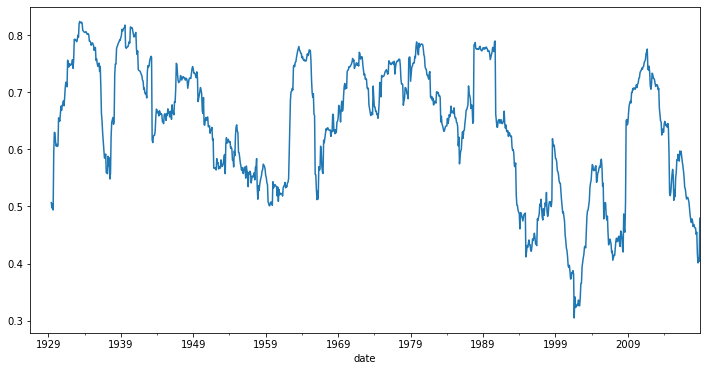

In [29]:
ind_tr36corr = ts_corr.groupby(level='date').apply(lambda cormat: cormat.values.mean())
ind_tr36corr.plot(figsize=(12,6))

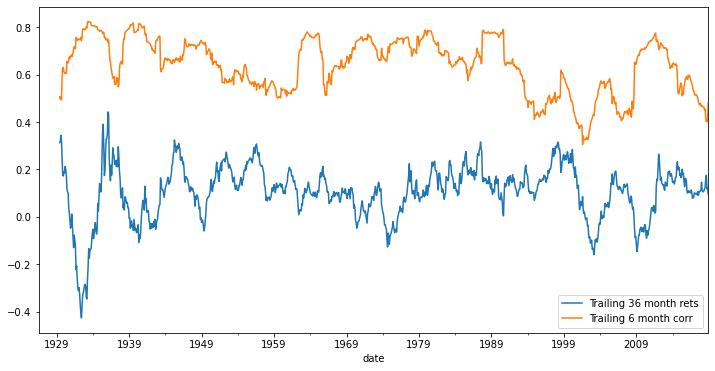

In [30]:
# total market index returns (36 month returns)
tmi_tr36rets.plot(label= "Trailing 36 month rets", figsize=(12,6), legend=True)
ind_tr36corr.plot(label="Trailing 6 month corr", legend=True)

The 36 month ret is in units of return and the other one is in units of correlation. Well superimpose the two graphs to understand better.

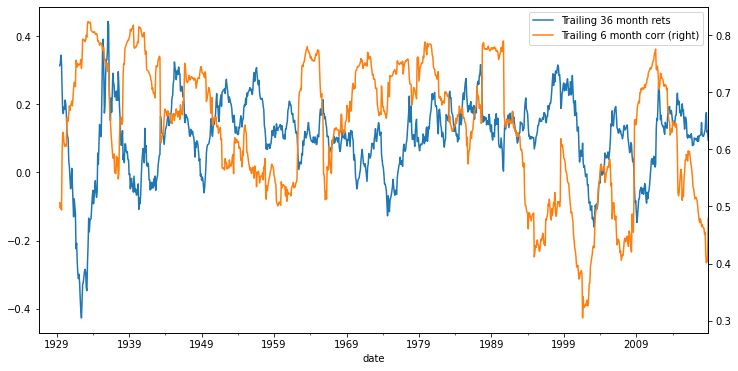

In [32]:
tmi_tr36rets.plot(label= "Trailing 36 month rets", figsize=(12,6), legend=True)
ind_tr36corr.plot(label="Trailing 6 month corr", legend=True, secondary_y = True) # This says that there is one more y axis.

We can see that, when the market is tanking, correlations are rising. When market is sort of rising, the correlations are sort of going back to normal.

This is avivid picture of why the diversification fails when you need it the most (when the market is falling apart). It is not exactly what will happen everytime. 

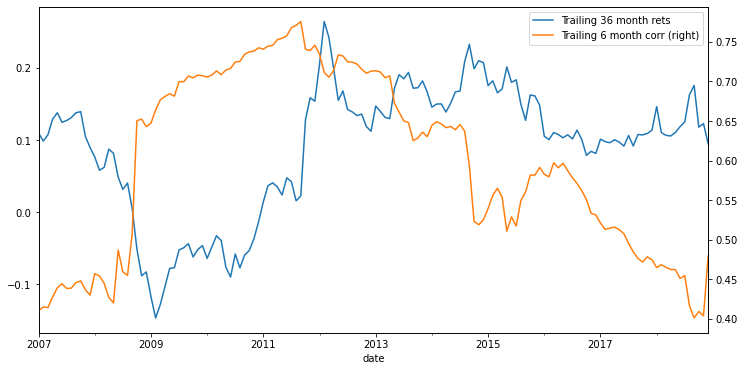

In [33]:
# Look at the plot from 2007
tmi_tr36rets["2007":].plot(label= "Trailing 36 month rets", figsize=(12,6), legend=True)
ind_tr36corr["2007":].plot(label="Trailing 6 month corr", legend=True, secondary_y = True)

We can see that, as the market is plummeting in 200-2009, correlations are spiking up fairy drammatically. So diversification will not help you.

In [34]:
# Find the highest correlation
tmi_tr36rets.corr(ind_tr36corr) # Correlation between trailing returns and trailing correlations

-0.28010065062884

The correlation between the average correlation of industries and returns is negative as calculated above. This shows that diversification does not help you when markets are crashing.